## import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
from glob import glob

from PIL import Image
from keras.applications import ResNet50
from keras.layers import Input
from keras import models, layers
from keras import Input
from keras.models import Model, load_model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add, Flatten
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

## Data preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths
data_dir = '/content/drive/MyDrive/eggs_size_yolov8/Eggs_Train_Test_Val' # data folder path

In [4]:
# Set Resize variable
IMAGE_SIZE = [224, 224] # This is my desired image size... and also ResNet50 accepts image of 224*224.
num_class = 4 # eggs number 0,1,2,3

In [5]:
os.listdir(data_dir)  # see folder insind data folder

['train', 'test', 'val']

In [6]:
def create_dataframe_data(split = 'train'):
    #params split: train|val|test
    row = []
    for image_name in glob(data_dir + f'/{split}/images/*.jpg'):
        if split == 'test':
            label = image_name.split('/')[-1].split('.')[0]
        else:
            label = image_name.split('/')[-1].split('_')[2].replace('เบอร์', '')
        row.append({'filename' : image_name, 'label' : label})
    df = pd.DataFrame(row)
    return df

## ดึงชื่อไฟล์ภาพ และ ผลเฉลย label (split เบอร์ไข่จากชื่อไฟล์)
train_df = create_dataframe_data('train')
val_df = create_dataframe_data('val')
print(len(train_df), len(val_df))
train_df.head()

382 96


,filename,label
0,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
1,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
2,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
3,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
4,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0


In [7]:
batch_size  = 32

## normalize image (ทำให้ค่า pixel ของรูปอยู่ระหว่าง 0-1) และ augmentation เพิ่มความหลากหลายให้รูปภาพ
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# normalize image (ทำให้ค่า pixel ของรูปอยู่ระหว่าง 0-1)
val_datagen = ImageDataGenerator(
    rescale = 1./255
)

# อ่าน data มาเป็นรูปแบบ tensor
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    y_col='label',
                                                    directory=None,
                                                    shuffle=True,
                                                    subset="training",
                                                    target_size=IMAGE_SIZE ,
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(val_df,
                                                        y_col='label',
                                                        directory=None,
                                                       shuffle=False,
                                                    #    subset="validation",
                                                        target_size=IMAGE_SIZE ,
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 382 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.


## Model

In [8]:
pth = "/content/drive/MyDrive/eggs_size_yolov8/Model_ckpt_500epoch.weights.h5" # ตั้งชื่อและที่อยู่สำหรับเซพโมเดล

cp = keras.callbacks.ModelCheckpoint(
    pth,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only = True
) # ตั้งค่า callback function เพื่อให้มันเซฟโมเดลที่มห้ค่า val_accuracy ที่ดีที่สุด (save best)



################### Model #################
resnet_model=Sequential()
resnet_model.add(keras.Input(shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3)))

pretrained_model=ResNet50(
    include_top=False,
    input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
    pooling='avg',
    classes= num_class,
    weights='imagenet'
) # load pretrain resnet50 โดยใช้ weight ที่ train บน ข้อมูล imagenet

for layer in pretrained_model.layers:
  layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dense(num_class,activation='softmax')) # จำนวน class
###########################################


# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## train model

In [9]:
hist = resnet_model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator)//batch_size,

    validation_steps = len(validation_generator)//batch_size,
    epochs = 50,
    callbacks=[cp]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 86s 6s/step - accuracy: 0.2121 - loss: 1.7852 - val_accuracy: 0.2812 - val_loss: 1.6494
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.2846 - loss: 1.5035 - val_accuracy: 0.2083 - val_loss: 1.4239
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 823ms/step - accuracy: 0.2808 - loss: 1.4109 - val_accuracy: 0.3021 - val_loss: 1.3976
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 519ms/step - accuracy: 0.2608 - loss: 1.4026 - val_accuracy: 0.1979 - val_loss: 1.3918
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 635ms/step - accuracy: 0.2525 - loss: 1.4212 - val_accuracy: 0.3125 - val_loss: 1.3578
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 441ms/step - accuracy: 0.2905 - loss: 1.3824 - val_accuracy: 0.1979 - val_loss: 1.4885
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 922ms/step - accuracy: 0.3094 - loss: 1.4739 - val_accuracy: 0.4167 - val_loss: 1.5434
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 552ms/step - accuracy: 0.3240 - loss: 1.4836 - val_accuracy: 0.1979 -

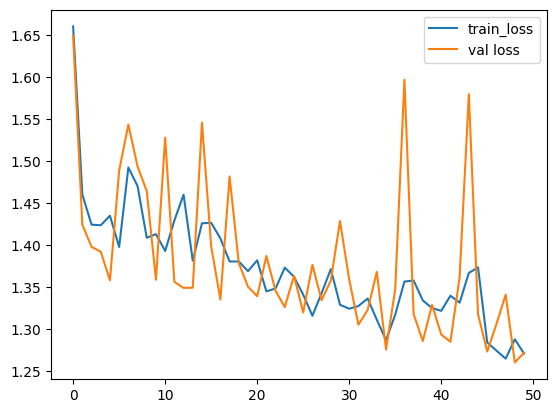

In [10]:
# Plot the Loss

plt.plot(hist.history['loss'], label = 'train_loss')
plt.plot(hist.history['val_loss'], label ='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

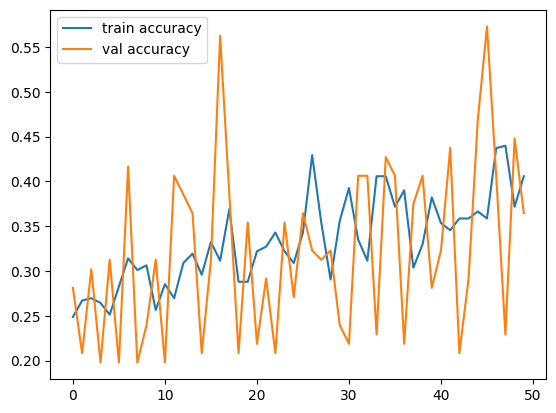

In [11]:
# Plot the Accuracy
plt.plot(hist.history['accuracy'], label = 'train accuracy')
plt.plot(hist.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()
# plt.savefig('valAccuracy')

In [12]:
# Save it as a h5 file
from tensorflow.keras.models import load_model
resnet_model.save('/content/drive/MyDrive/eggs_size_yolov8/egg_size_resnet50_500epoch.keras') # save model

## evaluate model

In [13]:
test_df = create_dataframe_data('test')

In [14]:
test_generator = val_datagen.flow_from_dataframe(test_df,
                                                        y_col='label',
                                                        directory=None,
                                                       shuffle=False,
                                                    #    subset="validation",
                                                        target_size=IMAGE_SIZE ,
                                                        batch_size=len(test_df),
                                                        class_mode='categorical')

Found 48 validated image filenames belonging to 4 classes.


In [15]:
resnet_model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3958 - loss: 1.2620


[1.2619892358779907, 0.3958333432674408]

In [16]:
resnet_model.load_weights(pth) # load weight ที่ดีที่สุด

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


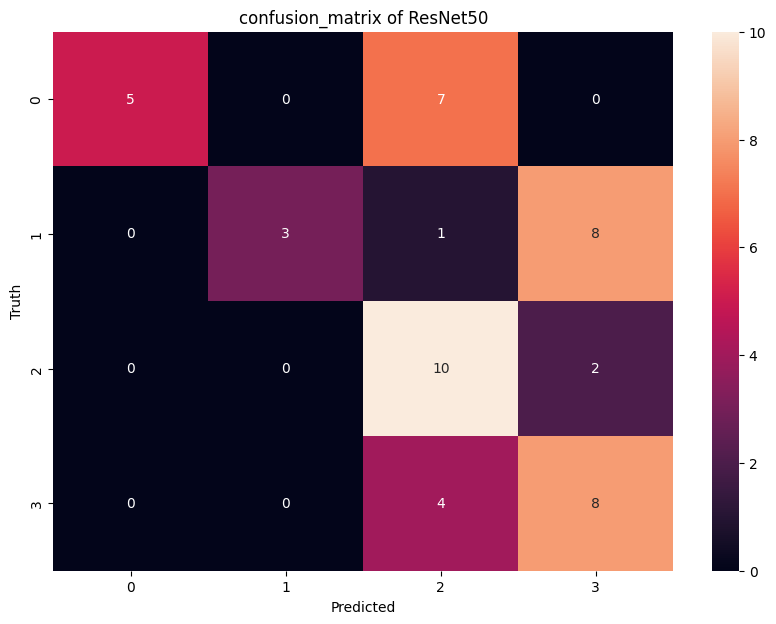


Classification Report of ResNet50:
              precision    recall  f1-score   support

           0       1.00      0.42      0.59        12
           1       1.00      0.25      0.40        12
           2       0.45      0.83      0.59        12
           3       0.44      0.67      0.53        12

    accuracy                           0.54        48
   macro avg       0.72      0.54      0.53        48
weighted avg       0.72      0.54      0.53        48



In [17]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import seaborn as sns

# Assuming `predicted_labels` are the predictions of our model on the test set
predicted_labels = resnet_model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)
true_labels = np.array(test_df['label'].astype('int').tolist())
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("confusion_matrix of ResNet50")
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

# Classification Report
print("\nClassification Report of ResNet50:")
print(classification_report(true_labels, predicted_labels))

In [18]:
test_df.head()

,filename,label
0,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
1,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
2,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
3,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0
4,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0


In [19]:
predicted_labels = resnet_model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


In [20]:
row_list = {}
for i in range(1, 16):
    predicted_labels = resnet_model.predict(test_generator)
    predicted_labels = np.argmax(predicted_labels, axis=1)
    row_list[f'รอบที่ {i}'] = predicted_labels.tolist()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 756ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 583ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


In [21]:
results = pd.concat([test_df,pd.DataFrame(row_list)], axis = 1)
results.head()

,filename,label,รอบที่ 1,รอบที่ 2,รอบที่ 3,รอบที่ 4,รอบที่ 5,รอบที่ 6,รอบที่ 7,รอบที่ 8,รอบที่ 9,รอบที่ 10,รอบที่ 11,รอบที่ 12,รอบที่ 13,รอบที่ 14,รอบที่ 15
0,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/content/drive/MyDrive/eggs_size_yolov8/Eggs_T...,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


In [22]:
for round_number in range(1, 16):
    results[f'รอบที่ {round_number}'] = np.where(results['label'] == results[f'รอบที่ {round_number}'], 'ถูก', 'ผิด')

In [23]:
results.to_excel("/content/drive/MyDrive/eggs_size_yolov8/restnet50_eggs_classification_results_500epoch.xlsx", index = False)# เซฟไฟล์